<div style="text-align: center; font-size: 30pt; font-weight: bold; margin: 1em 0em 1em 0em">Homework 1</div>

$\textbf{Authors}$ : Adel Nabli

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from time import time
from tqdm import tqdm

L:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# Load the data in the format of a design matrix for X
# and one-hot encode Y

mnist = tf.keras.datasets.mnist

(x, y),(x_test, y_test) = mnist.load_data()

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.166, random_state=42)

X_train = np.reshape(x_train, (len(x_train), 784))
X_val = np.reshape(x_val, (len(x_val), 784))
X_test = np.reshape(x_test, (len(x_test), 784))
Y_train = OneHotEncoder().fit_transform(np.reshape(y_train, (len(y_train),1))).toarray()
Y_test = OneHotEncoder().fit_transform(np.reshape(y_test, (len(y_test),1))).toarray()
Y_val = OneHotEncoder().fit_transform(np.reshape(y_val, (len(y_val),1))).toarray()

# Problem 1:

We want to build a MLP with two hidden layers with $h^1$ and $h^2$ hidden units. The data is given in the form of a design matrix $X \in \mathbb{R}^{n \times 784}$ and $\forall i \in [\![1,n]\!], y^i \in \mathbb{R}^{10}$ is the one-hot encoding of the label.
The output layer is parametrized by a $softmax$ function $s(z)_c = \dfrac{e^{z_c}}{\sum_c e^{z_c}}$.

* We choose the sigmoid function as a non linearity for both layers.
We have: $\sigma(z) = \dfrac{1}{1+ e^{-z}}$ and $\sigma'(z) = (1-\sigma(z))\sigma(z)$.


* Thus, our NN is computing, for each example $x \in \mathbb{R}^{784}$:

    - $A_1 = \sigma(W_1 x + b_1)$ with $W_1 \in \mathbb{R}^{h_1 \times 784}$ and $b_1 \in \mathbb{R}^{h_1}$
    - $A_2 = \sigma(W_2 A_1 + b_2)$ with $W_2 \in \mathbb{R}^{h_2 \times h_1}$ and $b_2 \in \mathbb{R}^{h_2}$
    - $O = s(W_3 A_2 + b_3)$ with $W_3 \in \mathbb{R}^{10 \times h_2}$ and $b_3 \in \mathbb{R}^{10}$


* The cross entropy loss is defined by: $l(y, O) = -\sum_{c=1}^{10} y_c\log(o_c)$ (recall that $y_c = \mathbb{1}_{label=c}$) which leads to a regularized empirical risk $\hat{R} = \dfrac{-1}{n} \sum_{i=1}^n \sum_{c=1}^{10} y_c^i\log(o_c^i) + \lambda \sum_{j=1}^3 ||W_j||_2^2$ if we consider an $L^2$ regularization.


* Our purpose is to learn each parameter $\theta \in \{ W_1, b_1, W_2, b_2, W_3, b_3 \}$ by **mini batch** gradient descent incrementaly: $\theta^{t+1} = \theta^t - \alpha_t \big( \dfrac{1}{|I_t|} \sum_{i_t \in I_t}\dfrac{\partial l}{\partial \theta}(x_{i_t}, y_{i_t}) + 2\lambda \theta^t \big)$  with $\alpha_t, I_t, x_{I_t}, y_{I_t}$ being respectively the learning rate, the mini-batch, the training examples and the corresponding labels at time $t$. We use the formula $\alpha_t = \dfrac{\alpha_0}{1 + \delta t}$ for the learning rate.


* For that, using the chain-rule, we derive:

    - $\dfrac{\partial l}{\partial b_3} = O - y$
    - $\dfrac{\partial l}{\partial W_3} = (O - y)A_2^{T}$
    - $\dfrac{\partial l}{\partial b_2} = \dfrac{\partial l}{\partial A_2}*(1-A_2)*A_2$ with $\dfrac{\partial l}{\partial A_2} = W_3 ^T  \dfrac{\partial l}{\partial b_3}$
    - $\dfrac{\partial l}{\partial W_2} = \dfrac{\partial l}{\partial b_2 } A_1 ^T$
    - $\dfrac{\partial l}{\partial b_1} = \dfrac{\partial l}{\partial A_1}*(1-A_1)*A_1$ with $\dfrac{\partial l}{\partial A_1} = W_2 ^T  \dfrac{\partial l}{\partial b_2}$
    - $\dfrac{\partial l}{\partial W_1} = \dfrac{\partial l}{\partial b_1 } x ^T$


* To initialize our parameters, we have three options:
    - **Zero**: we initialize with zeros
    - **Normal**: we initialize with $\mathcal{N}(0,1)$
    - **Glorot**: we initialize with $\mathcal{U}(-d^l, d^l)$ where $d^l = \sqrt{\dfrac{6}{h^{l-1}+h^l}}$

In [26]:
class NN(object):
    
    def __init__(self, hidden_dims=(1024,2048), initialization='glorot',
                 learning_rate=0.001, delta=0.7, mini_batch=32, regularization=0.001):
        
        dims = (784, hidden_dims[0], hidden_dims[1], 10)
        W1, b1, W2, b2, W3, b3 = self.initialize_weights(dims, initialization)
        parameters = dict()
        parameters['W1'] = W1
        parameters['b1'] = b1
        parameters['W2'] = W2
        parameters['b2'] = b2
        parameters['W3'] = W3
        parameters['b3'] = b3
        
        cache = dict()
        cache['x'] = None
        cache['A1'] = None
        cache['A2'] = None
        cache['O'] = None
        cache['y'] = None
        
        grad = dict()
        grad['W1'] = None
        grad['b1'] = None
        grad['W2'] = None
        grad['b2'] = None
        grad['W3'] = None
        grad['b3'] = None
        
        self.parameters = parameters
        self.cache = cache
        self.grad = grad
        self.learning_rate = learning_rate
        self.delta = delta
        self.mini_batch = mini_batch
        self.lambda_ = regularization
        self.cpt = 0
        self.n_samples = 0
        
    def initialize_weights(self,dims, initialization):
        
        # dims = (dim_input, h1, h2, dim_output)
        
        np.random.seed(42)
        
        d, h1, h2, o = dims
        b1 = np.zeros(h1)
        b2 = np.zeros(h2)
        b3 = np.zeros(o)
        
        if initialization == 'zero':
            
            W1 = np.zeros((h1, d))
            W2 = np.zeros((h2,h1))
            W3 = np.zeros((o,h2))
        
        elif initialization == 'normal':
            
            W1 = np.random.normal(0,1,(h1,d))
            W2 = np.random.normal(0,1,(h2,h1))
            W3 = np.random.normal(0,1,(o,h2))
        
        elif initialization == 'glorot':
            
            d1 = np.sqrt(6/(d+h1))
            d2 = np.sqrt(6/(h1+h2))
            d3 = np.sqrt(6/(h2+o))
            
            W1 = np.random.uniform(-d1,d1, (h1,d))
            W2 = np.random.uniform(-d2,d2, (h2,h1))
            W3 = np.random.uniform(-d3,d3, (o,h2))
        
        return(W1, b1, W2, b2, W3, b3)

    def forward(self,x,y):
        
        W1 = self.parameters['W1']
        b1 = self.parameters['b1']
        W2 = self.parameters['W2']
        b2 = self.parameters['b2']
        W3 = self.parameters['W3']
        b3 = self.parameters['b3']
        
        A1 = self.activation(np.dot(W1,x)+np.reshape(b1, (len(b1),1)))
        A2 = self.activation(np.dot(W2,A1)+np.reshape(b2, (len(b2),1)))
        O = self.softmax(np.dot(W3,A2)+np.reshape(b3, (len(b3),1)))
        
        self.cache['x'] = x
        self.cache['A1'] = A1
        self.cache['A2'] = A2
        self.cache['O'] = O
        self.cache['y'] = y

    def activation(self,U):
        
        return(1/(1+np.exp(-U)))

    def loss(self, O, y_true):
        
        W3 = self.parameters['W3']
        W2 = self.parameters['W2']
        W1 = self.parameters['W1']
        
        return(-np.mean(np.log(np.sum(O*y_true, axis=0))) + self.lambda_*(np.sum(W3**2)+np.sum(W1**2)+np.sum(W2**2)))
        
    def softmax(self,U):
        
        return(np.exp(U - np.log(np.sum(np.exp(U), axis=0))))

    def backward(self):
        
        x = self.cache['x']
        A1 = self.cache['A1']
        A2 = self.cache['A2']
        O = self.cache['O']
        y = self.cache['y']
        W3 = self.parameters['W3']
        W2 = self.parameters['W2']
        W1 = self.parameters['W1']
        n_batch = self.n_samples
        
        db3 = O-y
        self.grad['b3'] = np.mean(db3, axis=1)
        self.grad['W3'] = np.dot(db3, A2.T)*(1/n_batch) + 2*self.lambda_*W3
        dA2 = np.dot(W3.T,db3)
        db2 = dA2*(1-A2)*A2
        self.grad['b2'] = np.mean(db2, axis=1)
        self.grad['W2'] = np.dot(db2, A1.T)*(1/n_batch) + 2*self.lambda_*W2
        dA1 = np.dot(W2.T,db2)
        db1 = dA1*(1-A1)*A1
        self.grad['b1'] = np.mean(db1, axis=1)
        self.grad['W1'] = np.dot(db1, x.T)*(1/n_batch) + 2*self.lambda_*W1

    def update(self):
        
        alpha_0 = self.learning_rate
        delta = self.delta
        self.cpt += 1
        
        alpha = alpha_0/(1+delta*self.cpt)
        
        self.parameters['W1'] -= alpha*self.grad['W1']
        self.parameters['b1'] -= alpha*self.grad['b1']
        self.parameters['W2'] -= alpha*self.grad['W2']
        self.parameters['b2'] -= alpha*self.grad['b2']
        self.parameters['W3'] -= alpha*self.grad['W3']
        self.parameters['b3'] -= alpha*self.grad['b3']

    def train(self, X_train, Y_train, X_val, Y_val, n_epoch):
        
        n = len(X_train)
        n_batch = n//self.mini_batch
        ids = np.arange(n)
        averaged_loss_train = []
        averaged_loss_val = []
        accuracy_train = []
        accuracy_val = []
        
        for epoch in range(n_epoch):
            
            t0 = time()
            
            print('Epoch : %s' %epoch, '\n')
            
            np.random.shuffle(ids)
            risk = 0
            
            for i in tqdm(range(n_batch+1)):
                
                if i == n_batch and n%self.mini_batch > 0:
                    
                    self.n_samples = n%self.mini_batch
                    x = X_train[ids[i*self.mini_batch:],:].T
                    y = Y_train[ids[i*self.mini_batch:],:].T
                
                elif i < n_batch:
                    
                    self.n_samples = self.mini_batch
                    x = X_train[ids[i*self.mini_batch:(i+1)*self.mini_batch],:].T
                    y = Y_train[ids[i*self.mini_batch:(i+1)*self.mini_batch],:].T
                
                self.forward(x,y)
                self.backward()
                self.update()
                
                risk += self.loss(self.cache['O'], y)*self.n_samples
            
            risk = risk/n
            averaged_loss_train.append(risk)
            Y_predict_val = self.predict(X_val.T)
            averaged_loss_val.append(self.loss(Y_predict_val, Y_val.T))
            
            Y_predict_train = self.predict(X_train.T)
            y_predict_train = np.argmax(Y_predict_train, axis=0)
            y_true_train = np.where(Y_train==1)[1]
            y_predict_val = np.argmax(Y_predict_val, axis=0)
            y_true_val = np.where(Y_val==1)[1]
            accuracy_train.append(accuracy_score(y_true_train, y_predict_train))
            accuracy_val.append(accuracy_score(y_true_val, y_predict_val))
            
            t1 = time() - t0
            print('Training loss = %s' %risk, '\n')
            print('Time taken = %s' %t1, ' seconds' '\n')
            print('========================', '\n')
        
        fig = plt.figure(figsize=(16,8))
        ax1 = fig.add_subplot(221)
        ax1.plot(np.arange(n_epoch), averaged_loss_train, label='training loss')
        ax1.plot(np.arange(n_epoch), averaged_loss_val, label='Validation loss')
        ax1.set_title('Evolution of the averaged loss during training')
        ax1.legend()
        ax2 = fig.add_subplot(222)
        ax2.plot(np.arange(n_epoch), accuracy_train, label='accuracy train')
        ax2.plot(np.arange(n_epoch), accuracy_val, label='accuracy val')
        ax2.legend()
        ax2.set_title('Evolution of the accuracy during the training')
        
        plt.show()
    
    def predict(self, x):
        
        W1 = self.parameters['W1']
        b1 = self.parameters['b1']
        W2 = self.parameters['W2']
        b2 = self.parameters['b2']
        W3 = self.parameters['W3']
        b3 = self.parameters['b3']
        
        A1 = self.activation(np.dot(W1,x)+np.reshape(b1, (len(b1),1)))
        A2 = self.activation(np.dot(W2,A1)+np.reshape(b2, (len(b2),1)))
        O = self.softmax(np.dot(W3,A2)+np.reshape(b3, (len(b3),1)))
        
        return(O)
    
    def finite_difference(self, x, y):
        
        epsilons = [1e-2, 5e-3, 1e-3, 1e-4, 1e-5]
        
        W1 = self.parameters['W1']
        b1 = self.parameters['b1']
        W2 = self.parameters['W2']
        b2 = self.parameters['b2']
        W3 = self.parameters['W3']
        b3 = self.parameters['b3']
        
        A1 = self.activation(np.dot(W1,x)+b1)
        A2 = self.activation(np.dot(W2,A1)+b2)
        O = self.softmax(np.dot(W3,A2)+b3)
        
        db3 = O-y
        grad_W3 = np.dot(np.reshape(db3, (len(db3),1)), np.reshape(A2, (1, len(A2))))
        dA2 = np.dot(W3.T,db3)
        db2 = dA2*(1-A2)*A2
        grad_W2 = np.dot(np.reshape(db2, (len(db2),1)), np.reshape(A1, (1, len(A1))))
        
        max_diff = []
        
        for epsilon in epsilons:
            
            diff = []
            
            for k in range(10):
            
                W2_plus = W2.copy()
                W2_minus = W2.copy()
            
                W2_plus[0,k] += epsilon
                W2_minus[0,k] -= epsilon

                A2_plus = self.activation(np.dot(W2_plus,A1)+b2)
                O_plus = self.softmax(np.dot(W3,A2_plus)+b3)
                loss_plus = -np.log(np.dot(O_plus,y)) + self.lambda_*(np.sum(W3**2)+np.sum(W1**2)+np.sum(W2_plus**2))

                A2_minus = self.activation(np.dot(W2_minus,A1)+b2)
                O_minus = self.softmax(np.dot(W3,A2_minus)+b3)
                loss_minus = -np.log(np.dot(O_minus,y)) + self.lambda_*(np.sum(W3**2)+np.sum(W1**2)+np.sum(W2_minus**2))
        
                estimated_grad = (loss_plus-loss_minus)/(2*epsilon)
                diff.append(np.abs(grad_W2[0,k]-estimated_grad))
        
            max_diff.append(max(diff))
        
        plt.figure(figsize=(8,8))
        plt.plot(1/np.array(epsilons), max_diff)
        plt.title('Evolution of the maximum of the difference between true and approximated gradient')
        plt.show()

Epoch : 0 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:25<00:00, 31.43it/s]


Training loss = 3.8653905686042322 

Time taken = 28.584790229797363  seconds


Epoch : 1 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:24<00:00, 31.51it/s]


Training loss = 1.4907152127507879 

Time taken = 28.254652500152588  seconds


Epoch : 2 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:24<00:00, 31.90it/s]


Training loss = 1.1836682009635848 

Time taken = 28.174571752548218  seconds


Epoch : 3 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:25<00:00, 29.74it/s]


Training loss = 1.0463249070685783 

Time taken = 28.994154930114746  seconds


Epoch : 4 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:24<00:00, 31.47it/s]


Training loss = 0.9662297155346237 

Time taken = 28.272625207901  seconds


Epoch : 5 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:24<00:00, 31.65it/s]


Training loss = 0.9126329238821029 

Time taken = 28.172643184661865  seconds


Epoch : 6 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:24<00:00, 31.62it/s]


Training loss = 0.8749065697126813 

Time taken = 28.187423706054688  seconds


Epoch : 7 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:24<00:00, 31.50it/s]


Training loss = 0.8455178991241702 

Time taken = 28.306345462799072  seconds


Epoch : 8 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:25<00:00, 31.19it/s]


Training loss = 0.8225894905489602 

Time taken = 28.585617542266846  seconds


Epoch : 9 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:24<00:00, 31.42it/s]


Training loss = 0.803969306996986 

Time taken = 28.35233497619629  seconds


Epoch : 10 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:24<00:00, 31.53it/s]


Training loss = 0.7888208466429659 

Time taken = 28.30356240272522  seconds


Epoch : 11 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:24<00:00, 31.42it/s]


Training loss = 0.7757600325235318 

Time taken = 28.3667151927948  seconds


Epoch : 12 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:24<00:00, 32.50it/s]


Training loss = 0.7648577014055062 

Time taken = 28.27474284172058  seconds


Epoch : 13 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:24<00:00, 31.40it/s]


Training loss = 0.7554740924806208 

Time taken = 28.38373827934265  seconds


Epoch : 14 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:25<00:00, 31.02it/s]


Training loss = 0.7469717191344186 

Time taken = 28.737276315689087  seconds


Epoch : 15 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:24<00:00, 31.49it/s]


Training loss = 0.7398784112352235 

Time taken = 28.289974689483643  seconds


Epoch : 16 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:25<00:00, 31.02it/s]


Training loss = 0.7333090270291465 

Time taken = 28.731390953063965  seconds


Epoch : 17 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:24<00:00, 31.78it/s]


Training loss = 0.7275685419093506 

Time taken = 28.3408420085907  seconds


Epoch : 18 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:24<00:00, 32.36it/s]


Training loss = 0.722208329765165 

Time taken = 28.412489414215088  seconds


Epoch : 19 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:25<00:00, 30.98it/s]


Training loss = 0.7175721869991418 

Time taken = 28.854212284088135  seconds




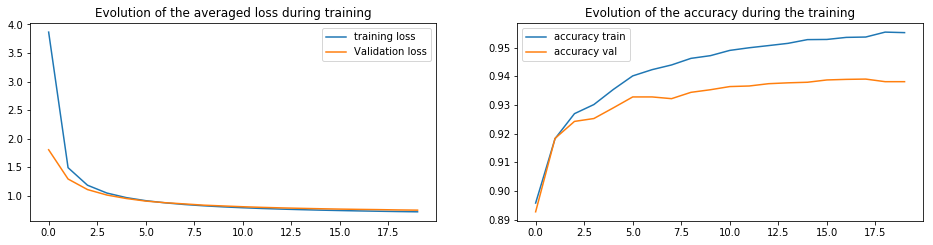

In [27]:
MLP = NN(hidden_dims=(600,700), initialization='glorot', learning_rate=0.5, delta=2e-2, mini_batch=64, regularization=0.01)
MLP.train(X_train, Y_train, X_val, Y_val, 20)

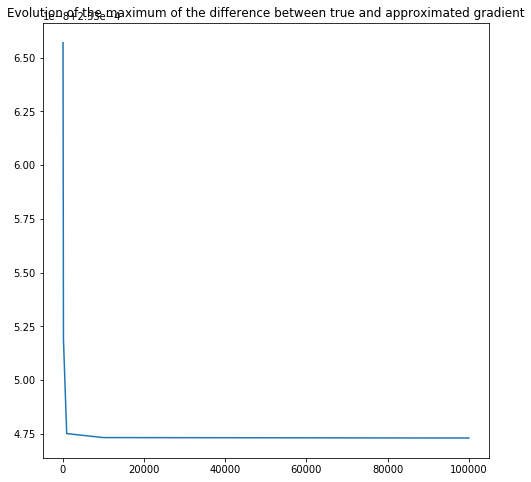

In [28]:
MLP.finite_difference(X_train[0,:], Y_train[0,:])